In [2]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import time
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load training data from Google Drive
df = pd.read_csv('/content/drive/MyDrive/merged_data.csv')

# Load test data from Google Drive
test_df = pd.read_csv('/content/drive/MyDrive/review.csv')

# Column names of the dataset
user_col, name_col, rating_col = 'user_id', 'name', 'stars'

# Filter training data: Keep only users and items with minimum interactions
# Keep only users and items with at least 5 ratings
filtered_df = df.groupby(user_col).filter(lambda x: len(x) >= 5)
filtered_df = filtered_df.groupby(name_col).filter(lambda x: len(x) >= 5)

# Reduce dataset size: Limit to 10,000 rows to save memory
filtered_df = filtered_df.sample(n=10000, random_state=42)

# Convert user_id and name to numeric values
user_ids, user_names = pd.factorize(filtered_df[user_col])
name_ids, name_labels = pd.factorize(filtered_df[name_col])

ratings_data = filtered_df[rating_col].values.astype(np.int32)

# Create a CSR matrix for training data
ratings = csr_matrix(
    (ratings_data, (user_ids, name_ids)),
    shape=(len(np.unique(user_ids)), len(np.unique(name_ids)))
).toarray()

# Convert to DataFrame
user_item_matrix = pd.DataFrame(ratings, index=user_names, columns=name_labels)
print(user_item_matrix.head())

Mounted at /content/drive
                        Apple Store  Nando's PERi-PERi  Tango  \
RW4VosmJhHtFzNIxxFRDNQ            1                  0      0   
Rpqf0uVt6XENIvrbaSciiA            0                  4      0   
TFw7YRiyl4r2nw3_JFh2Ww            0                  0      2   
_BcWyKQL16ndpBdggh2kNA            0                  0      0   
NAtkmn07-dNVA6YMqZCs6Q            0                  0      0   

                        Jules Thin Crust  Walden's Coffeehouse  Pizza Hut  \
RW4VosmJhHtFzNIxxFRDNQ                 0                     0          0   
Rpqf0uVt6XENIvrbaSciiA                 0                     0          0   
TFw7YRiyl4r2nw3_JFh2Ww                 0                     0          0   
_BcWyKQL16ndpBdggh2kNA                 5                     0          0   
NAtkmn07-dNVA6YMqZCs6Q                 0                     5          0   

                        Imo's Pizza  Walmart Supercenter  XIX Nineteen  \
RW4VosmJhHtFzNIxxFRDNQ            0           

In [3]:


class MatrixFactorization():
    def __init__(self, ratings, n_factors=100, l_rate=0.01, alpha=0.01, n_iter=100):
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.non_zero_row_ind, self.non_zero_col_ind = ratings.nonzero()
        self.n_interac = len(ratings[np.where(ratings != 0)])
        self.ind_lst = list(range(self.n_interac))
        self.n_factors = n_factors
        self.l_rate = l_rate  # eta0 Constant that multiplies the update term
        self.alpha = alpha  # lambda Constant that multiplies the regularization term
        self.n_iter = n_iter
        self.mse_lst = []
        self.wait = 10
        self.tol = 1e-3
        self.n_iter_no_change = 10
        self.verbose = True
        self.stop = False

    def initialize(self):
        self.now = time.time()
        # Initialize Bias Values
        self.user_biases = np.zeros(self.n_users)
        self.item_biases = np.zeros(self.n_items)
        # Initialize user & item vectors
        self.user_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1/self.n_factors, size=(self.n_items, self.n_factors))
        # Compute global bias
        self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
        self.evaluate_the_model(0)

    def predict(self, u, i):
        return self.global_bias + self.user_biases[u] + self.item_biases[i] + self.user_vecs[u] @ self.item_vecs[i]

    def update_biases_and_vectors(self, error, u, i):
        # Update biases
        self.user_biases[u] += self.l_rate * (error - self.alpha * self.user_biases[u])
        self.item_biases[i] += self.l_rate * (error - self.alpha * self.item_biases[i])
        # Update User and item Vectors
        self.user_vecs[u, :] += self.l_rate * (error * self.item_vecs[i, :] - self.alpha * self.user_vecs[u, :])
        self.item_vecs[i, :] += self.l_rate * (error * self.user_vecs[u, :] - self.alpha * self.item_vecs[i, :])

    def evaluate_the_model(self, epoch):
        tot_square_error = 0
        for index in self.ind_lst:
            # Extracting user item information indices in which we have a rating
            u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
            pred_rat = self.predict(u, i)
            tot_square_error += (self.ratings[u, i] - pred_rat) ** 2
        mse = tot_square_error / self.n_interac
        self.mse_lst.append(mse)
        if self.verbose:
            print(f"---> Epoch {epoch}")
            temp = np.round(time.time() - self.now, 3)
            print(f"ave mse {np.round(self.mse_lst[-1], 3)} ===> Total training time: {temp} seconds.")

    def early_stopping(self, epoch):
        if (self.mse_lst[-2] - self.mse_lst[-1]) <= self.tol:
            if self.wait == self.n_iter_no_change:
                temp = np.round(time.time() - self.now, 3)
                if self.verbose: print(f"Convergence after {epoch} epochs time took: {temp} seconds.")
                self.stop = True
                self.conv_epoch_num = epoch
            self.wait += 1
        else:
            self.wait = 0

    def fit(self):
        self.initialize()
        for epoch in range(1, self.n_iter):
            np.random.shuffle(self.ind_lst)
            if not self.stop:
                for index in self.ind_lst:
                    u, i = self.non_zero_row_ind[index], self.non_zero_col_ind[index]
                    pred_rat = self.predict(u, i)
                    error = self.ratings[u, i] - pred_rat
                    self.update_biases_and_vectors(error, u, i)
                self.evaluate_the_model(epoch)
                self.early_stopping(epoch)
        self.conv_epoch_num = epoch
        self.plot_the_score()

    def result(self):
        return self.user_vecs, self.item_vecs

    def plot_the_score(self):
        plt.figure(figsize=(18, 6))
        plt.plot(range(1, 1 + len(self.mse_lst)), self.mse_lst, marker='o')
        plt.title("Training MSE loss vs epochs", fontsize=20)
        plt.xlabel('Number of epochs', fontsize=18)
        plt.ylabel('Mean square error', fontsize=18)
        plt.xticks(range(1, self.conv_epoch_num + 5), fontsize=15, rotation=90)
        plt.yticks(np.linspace(min(self.mse_lst), max(self.mse_lst), 15), fontsize=15)
        plt.grid()
        plt.show()

---> Epoch 0
ave mse 1.957 ===> Total training time: 0.191 seconds.
---> Epoch 1
ave mse 1.805 ===> Total training time: 0.812 seconds.
---> Epoch 2
ave mse 1.705 ===> Total training time: 1.106 seconds.
---> Epoch 3
ave mse 1.626 ===> Total training time: 1.814 seconds.
---> Epoch 4
ave mse 1.558 ===> Total training time: 2.617 seconds.
---> Epoch 5
ave mse 1.497 ===> Total training time: 3.5 seconds.
---> Epoch 6
ave mse 1.442 ===> Total training time: 4.893 seconds.
---> Epoch 7
ave mse 1.391 ===> Total training time: 6.556 seconds.
---> Epoch 8
ave mse 1.344 ===> Total training time: 8.91 seconds.
---> Epoch 9
ave mse 1.3 ===> Total training time: 10.554 seconds.
---> Epoch 10
ave mse 1.259 ===> Total training time: 12.224 seconds.
---> Epoch 11
ave mse 1.219 ===> Total training time: 13.381 seconds.
---> Epoch 12
ave mse 1.182 ===> Total training time: 14.026 seconds.
---> Epoch 13
ave mse 1.147 ===> Total training time: 14.47 seconds.
---> Epoch 14
ave mse 1.112 ===> Total traini

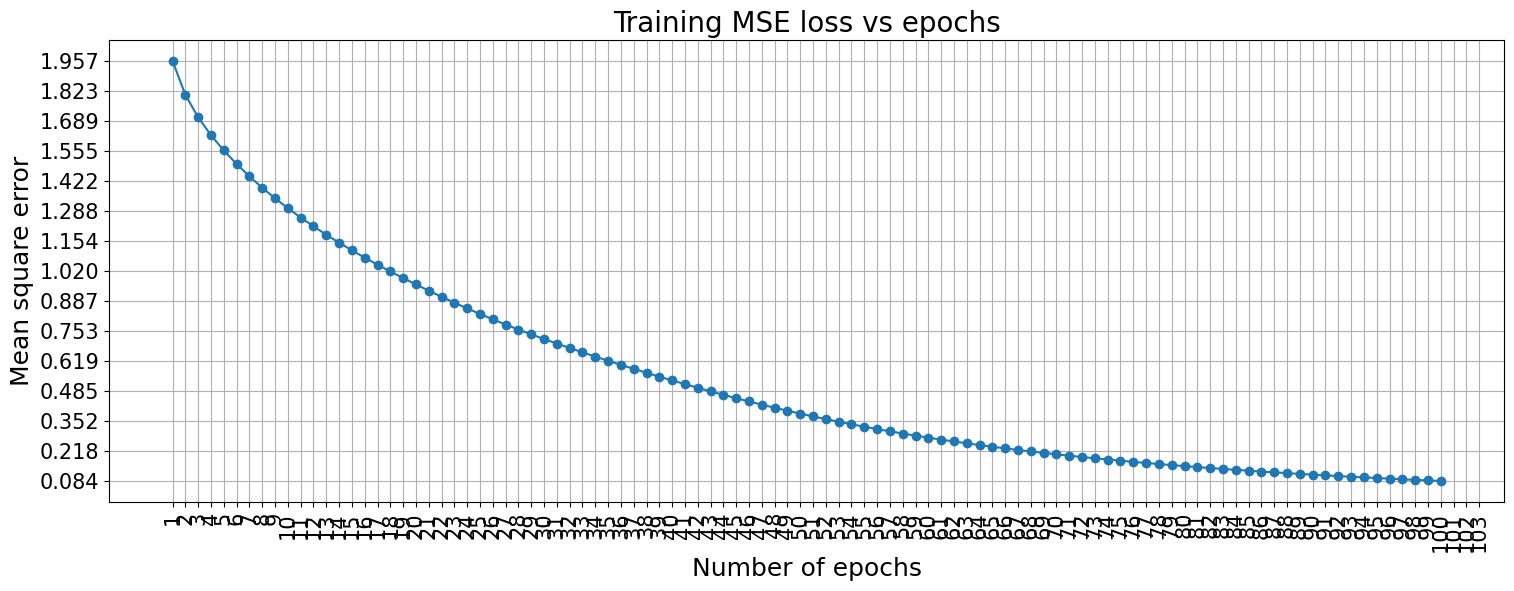

In [4]:
# 모델 초기화 및 학습
obj = MatrixFactorization(ratings)
obj.fit()

user_vecs, item_vecs = obj.result()

# 테스트 데이터 준비
test_user_ids, _ = pd.factorize(test_df[user_col])
test_item_ids, _ = pd.factorize(test_df[name_col])
test_ratings = pd.to_numeric(test_df[rating_col], errors='coerce').fillna(0).values

# 테스트 세트에 대한 예측 계산
predictions = [
    obj.predict(test_user_ids[i], test_item_ids[i])
    if (test_user_ids[i] < len(user_vecs) and test_item_ids[i] < len(item_vecs))
    else np.nan
    for i in range(len(test_user_ids))
]


In [5]:
# 테스트 세트에 대한 예측 평가
test_df['predicted_rating'] = predictions
mse = ((pd.to_numeric(test_df[rating_col], errors='coerce') - test_df['predicted_rating']) ** 2).mean()
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse}")

# 랜덤 사용자 선택 후 상위 k개 추천 항목 출력
random_user = np.random.choice(test_user_ids)
item_scores = [(i, obj.predict(random_user, i)) for i in range(len(item_vecs))]
not_sorted_item_scores = item_scores
item_scores = sorted(item_scores, key=lambda x: x[1], reverse=True)

k = 5
recommendation_items = []
print(f"\nTop {k} recommendations for user {random_user}:")
for idx, score in item_scores[:k]:
    recommendation_items.append(item_scores[idx][0])
    print('item index: ', item_scores[idx][0])
    print(f"Restaurant: {name_labels[idx]}, Predicted Rating: {score}")

Test RMSE: 1.7220193264305088

Top 5 recommendations for user 1856:
item index:  2445
Restaurant: Fatdogs, Predicted Rating: 6.749503122090651
item index:  3212
Restaurant: Strange Donuts, Predicted Rating: 6.744560306870267
item index:  1582
Restaurant: Ruby Buffet, Predicted Rating: 6.662138033713156
item index:  554
Restaurant: TacoSon, Predicted Rating: 6.436859007263191
item index:  797
Restaurant: Sky Cafe, Predicted Rating: 6.072996184432302


In [6]:
# 아이템 유사도 계산
ame_similarity_matrix = cosine_similarity(item_vecs)

name_similarity_df = pd.DataFrame(ame_similarity_matrix, index=name_labels, columns=name_labels)

# 결과 데이터프레임 생성
result_df = pd.DataFrame(ame_similarity_matrix, index=name_labels, columns=name_labels)
result_df


,Apple Store,Nando's PERi-PERi,Tango,Jules Thin Crust,Walden's Coffeehouse,Pizza Hut,Imo's Pizza,Walmart Supercenter,XIX Nineteen,Jockamo Upper Crust Pizza,...,DoubleTree by Hilton Hotel Philadelphia Airport,The Donut + Dog,Sesame Chinese Restaurant,Frank's Pizza,Aman's Indian Bistro,Alfred Angelo Bridal,Dollarama,United Parcel Service,Back Bar,Solar Nails & Spa
Apple Store,1.000000,-0.122407,0.049092,-0.038583,-0.127612,0.083069,-0.122588,-0.161138,0.088849,0.220719,...,0.018304,-0.069433,-0.024478,0.203750,-0.009871,0.126877,0.169596,0.046605,0.072582,0.118830
Nando's PERi-PERi,-0.122407,1.000000,-0.059517,-0.077639,0.004151,0.010568,0.027974,0.107728,0.154087,0.159943,...,0.139878,-0.000091,0.040297,-0.175874,0.052354,-0.078222,-0.082338,-0.064074,0.010594,-0.012736
Tango,0.049092,-0.059517,1.000000,0.034246,0.016401,0.095054,0.055905,-0.019212,0.083415,-0.004609,...,-0.111121,-0.030698,0.052935,0.028586,0.105263,-0.000143,-0.063475,0.131823,0.030847,-0.040588
Jules Thin Crust,-0.038583,-0.077639,0.034246,1.000000,0.232695,-0.030189,0.141008,0.048331,-0.073970,-0.131771,...,-0.057225,0.040270,0.169713,0.019793,-0.093194,0.013001,0.039364,-0.012095,0.097458,0.051338
Walden's Coffeehouse,-0.127612,0.004151,0.016401,0.232695,1.000000,-0.033799,0.051425,0.193314,-0.229206,-0.045176,...,0.011227,0.044412,0.021248,-0.027221,-0.015805,0.134620,0.016409,-0.149286,-0.025760,-0.003706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Alfred Angelo Bridal,0.126877,-0.078222,-0.000143,0.013001,0.134620,-0.009941,0.030463,-0.129261,-0.042024,-0.041952,...,0.038175,-0.251593,0.108000,0.153845,-0.004407,1.000000,0.087920,-0.122860,-0.194142,-0.055762
Dollarama,0.169596,-0.082338,-0.063475,0.039364,0.016409,0.011811,0.006977,0.141931,-0.098329,-0.082254,...,-0.010840,-0.027671,0.017434,-0.003531,-0.091743,0.087920,1.000000,0.092239,-0.046824,-0.002168
United Parcel Service,0.046605,-0.064074,0.131823,-0.012095,-0.149286,-0.154497,-0.025017,-0.118286,0.027385,-0.062491,...,0.053781,-0.004087,0.007522,-0.102169,-0.069352,-0.122860,0.092239,1.000000,0.070132,0.015844
Back Bar,0.072582,0.010594,0.030847,0.097458,-0.025760,-0.032772,0.075505,0.139732,0.040652,-0.069810,...,-0.021254,-0.043585,0.161299,-0.082878,-0.072539,-0.194142,-0.046824,0.070132,1.000000,0.146971


In [40]:
# evaluation
print('test_df with predictions:\n', test_df)
print('\n')

random_user_name = test_df['user_id'][random_user]
print('random user index:', random_user)
print('random user name:', random_user_name)
print('item_scores:', not_sorted_item_scores)
print('items that user rated:\n', test_df[test_df['user_id'] == random_user_name])
print('recommendated items: ', recommendation_items)
print('\n')

# predicted ratings의 평가
# mse and rmse
print('mse: ', mse)
print('rmse: ', rmse)
print('\n')

# 랜덤한 한 유저에 대한 rank 평가
# precision@k
user_rated_items = test_df[test_df['user_id'] == random_user_name]['business_id']
true_positive = sum((item in user_rated_items for item in recommendation_items))
precision = true_positive / k
print(f'precision@{k} of user {random_user_name}: {precision}')

# recall@k
recall = true_positive / len(user_rated_items)
print(f'recall@{k} of user {random_user_name}: {recall}')

test_df with predictions:
          Unnamed: 0                 user_id             business_id  stars  \
0                 0  bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ    4.0   
1                 1  aG7fzKXqZuG-0vW6NFt8zA  e4Vwtrqf-wpJfwesgvdgxQ    5.0   
2                 2  mUIww29FcFs5E67eZsMdvw  e4Vwtrqf-wpJfwesgvdgxQ    5.0   
3                 3  uzHh5QORBRg8PkO4yg4rIg  e4Vwtrqf-wpJfwesgvdgxQ    5.0   
4                 4  3bRv6h4oOu1lk7N0EEi4DA  e4Vwtrqf-wpJfwesgvdgxQ    5.0   
...             ...                     ...                     ...    ...   
2085502     2085502  vwdTSv7LGPL9dHZySD1goA  ELX24jqeRWZbR-Dq6wrnLQ    5.0   
2085503     2085503  ys4OGcaCUfQxNzaJrjpnLg  ELX24jqeRWZbR-Dq6wrnLQ    1.0   
2085506     2085506  SLAzy7Wg-KKPJAPElQBxHA  ELX24jqeRWZbR-Dq6wrnLQ    3.0   
2085507     2085507  a4wr0eMRHjFqI66JoGpXog  Tj9FmBCHd84kjAE9vcoBnw    1.0   
2085511     2085511  baGaUEUuXYQvTR9h4n9VKw  Tj9FmBCHd84kjAE9vcoBnw    1.0   

                name  
0            

In [ ]:
# 모든 유저에 대한 rank 평가
# Mean Average Precision@k
test_df = test_df.drop_duplicates(subset=['user_id'])  # make user ids unique
test_user_ids = test_df['user_id']
average_precision_sum = 0

for test_user_id in test_user_ids:
  test_user_indices = test_df[test_df['user_id'] == test_user_id].index
  if len(test_user_indices) <= 0: continue
  test_user_index = test_df[test_df['user_id'] == test_user_id].index[0]
  user_rated_items = test_df[test_df['user_id'] == test_user_id]['business_id']

  if test_user_index >= len(item_vecs): continue
  item_scores = [(i, obj.predict(test_user_index, i)) for i in range(len(item_vecs))]
  item_scores = sorted(item_scores, key=lambda x: x[1], reverse=True)

  precision_sum = 0

  # calculate precision in range 1 to k
  for k_i in range(1,  k + 1):
      recommendation_items = []
      for idx, score in item_scores[:k_i]:
          recommendation_items.append(item_scores[idx][0])

      # calculate Average Precision
      # if item is rated by user, relevance is 1 and otherwise 0
      # 0 make Average Precision to 0 so, calculate only when relevance is 1
      if recommendation_items[k_i - 1] in user_rated_items:
        true_positive_of_i = sum((item in user_rated_items for item in recommendation_items[:k_i]))
        precision_of_i = true_positive_of_i / k_i
        precision_sum += precision_of_i

  average_precision = precision_sum / len(user_rated_items)
  average_precision_sum += average_precision
  print(f'Average Precision of User {test_user_index}: {average_precision}')

mean_average_precision = average_precision_sum / len(test_user_ids)
print(f'mean average precision@{k}: {mean_average_precision}')

Average Precision of User 0: 0.0
Average Precision of User 1: 0.0
Average Precision of User 2: 0.0
Average Precision of User 3: 0.0
Average Precision of User 4: 0.0
Average Precision of User 6: 0.0
Average Precision of User 7: 0.0
Average Precision of User 8: 0.0
Average Precision of User 9: 0.0
Average Precision of User 10: 0.0
Average Precision of User 11: 0.0
Average Precision of User 12: 0.0
Average Precision of User 13: 0.0
Average Precision of User 14: 0.0
Average Precision of User 15: 0.0
Average Precision of User 16: 0.0
Average Precision of User 17: 0.0
Average Precision of User 18: 0.0
Average Precision of User 20: 0.0
Average Precision of User 21: 0.0
Average Precision of User 23: 0.0
Average Precision of User 24: 0.0
Average Precision of User 25: 0.0
Average Precision of User 26: 0.0
Average Precision of User 27: 0.0
Average Precision of User 28: 0.0
Average Precision of User 29: 0.0
Average Precision of User 30: 0.0
Average Precision of User 31: 0.0
Average Precision of Us